In [1]:
import os
import warnings
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
import glob

# Let's try out making some beta radar plots
from lsst.sims.maf.runComparison import RunComparison

/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/runComparison/runComparison.py:24: UserWarning: 
The generateDiffHtml method requires bokeh to be installed
but it is not needed to use the other methods in this class.
Run: pip install bokeh then restart your jupyter notebook kernel.
  'but it is not needed to use the other methods in this class.'+'\n'+


In [2]:
# Starting with example at
# https://matplotlib.org/examples/api/radar_chart.html

from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection

def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    # rotate theta such that the first axis is at the top
    theta += np.pi/2
    
    # FFS, need to make sure we don't go over 360
    theta = theta % (2.*np.pi)

    def draw_poly_patch(self):
        verts = unit_poly_verts(theta)
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_patch(self):
        # unit circle centered on (0.5, 0.5)
        return plt.Circle((0.5, 0.5), 0.5)

    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_patch = patch_dict[frame]

        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            return self.draw_patch()

        def _gen_axes_spines(self):
            if frame == 'circle':
                return PolarAxes._gen_axes_spines(self)
            # The following is a hack to get the spines (i.e. the axes frame)
            # to draw correctly for a polygon frame.

            # spine_type must be 'left', 'right', 'top', 'bottom', or `circle`.
            spine_type = 'circle'
            verts = unit_poly_verts(theta)
            # close off polygon by repeating first vertex
            verts.append(verts[0])
            path = Path(verts)

            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}

    register_projection(RadarAxes)
    return theta


def unit_poly_verts(theta):
    """Return vertices of polygon for subplot axes.

    This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
    """
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts

In [3]:
# Run names
# Note that the run names are not entirely standard -- some are _v1.5_10yrs and some are v1.5_10yrs.

# just sym-link this in whereever one might be running
dbdir = '../potential_schedulers'
run_names = [os.path.split(i)[-1].replace('.db', '') for i in glob.glob(os.path.join(dbdir, '*10yrs.db'))]

short_run_names = [run.replace('v1.5_10yrs', '').rstrip('_') for run in run_names]

# temp remove the new one
run_names = [run for run in run_names if 'scale' not in run]
short_run_names = [run for run in short_run_names if 'scale' not in run]

short_run_names



['mw_heavy',
 'ss_heavy',
 'rolling_exgal_mod2_dust_sdf_0.20',
 'ddf_heavy',
 'baseline_nexp1',
 'barebones',
 'baseline_nexp2',
 'dm_heavy']

In [4]:
# then get list of science batch outputs

sciroot = '../potential_schedulers/'
glanceroot =  '../potential_schedulers/'
ssoroot = '../sso/'

all_runs = [run for run in run_names]
sci_dirs = [os.path.join(sciroot, f'sci_{run}') for run in run_names]

# and list of NEO outputs

all_runs += [run for run in run_names]
sso_dirs = [os.path.join(ssoroot, f'{run}/sso') for run in run_names]

# and add glance outputs

all_runs += [run for run in run_names]
glance_dirs = [os.path.join(glanceroot, f'{run}') for run in run_names]

all_runs = short_run_names + short_run_names + short_run_names
all_dirs = sci_dirs + glance_dirs + sso_dirs

In [12]:
# Connect to all of the resultsDb output databases
rc = RunComparison(baseDir='', runlist=all_runs, rundirs=all_dirs)
# Get the info on all of their summary metrics.
mdict = rc.buildMetricDict() 
# rc.addSummaryStats(mdict) # this just adds ALL metrics 
rc.summaryStats

In [6]:
list(mdict.keys())

['fO All visits HealpixSlicer',
 'Parallax Error @ 22.4 All visits HealpixSlicer',
 'Parallax Error @ 24.0 All visits HealpixSlicer',
 'Normalized Parallax @ 22.4 All visits HealpixSlicer',
 'Normalized Parallax @ 24.0 All visits HealpixSlicer',
 'Parallax Coverage @ 22.4 All visits HealpixSlicer',
 'Parallax Coverage @ 24.0 All visits HealpixSlicer',
 'Parallax-DCR degeneracy @ 22.4 All visits HealpixSlicer',
 'Parallax-DCR degeneracy @ 24.0 All visits HealpixSlicer',
 'Proper Motion Error @ 20.5 All visits HealpixSlicer',
 'Proper Motion Error @ 24.0 All visits HealpixSlicer',
 'Normalized Proper Motion @ 20.5 All visits HealpixSlicer',
 'Normalized Proper Motion @ 24.0 All visits HealpixSlicer',
 'RapidRevisits All visits HealpixSlicer',
 'Periodic_amp_1.00_mag_21  HealpixSlicer',
 'Periodic_amp_1.00_mag_24  HealpixSlicer',
 'Periodic_amp_0.10_mag_21  HealpixSlicer',
 'Periodic_amp_0.10_mag_24  HealpixSlicer',
 'Periodic_amp_0.05_mag_21  HealpixSlicer',
 'Periodic_amp_0.05_mag_24  H

In [13]:
# If there are only some we want to focus on instead of reading all of them .. (much faster)
keys = ['fO All visits HealpixSlicer', 
        'Parallax Error @ 24.0 All visits HealpixSlicer',
        'Proper Motion Error @ 24.0 All visits HealpixSlicer', 
        'Periodic_amp_0.10_mag_24  HealpixSlicer',
        'TDEsAsciiMetric  HealpixSlicer',
        'SNIa_PrePeak  UserPointsSlicer',
        'GalaxyCountsMetric_extended i HealpixSlicer',
        'CumulativeCompleteness NEO 3 pairs in 15 nights detection loss MoObjSlicer',
        'CumulativeCompleteness@Time@H=22.00 NEO 3 pairs in 15 nights detection loss MoObjSlicer',
        'N stars to Precision 0.10 g HealpixSlicer']
for k in keys:
    if k not in mdict:
        print(k)

In [14]:
mdict_sub = {}
for k in keys:
    mdict_sub[k] = mdict[k]
rc.addSummaryStats(mdict_sub)

In [ ]:
# something is still odd about the sso metrics .. the summary stats should have more info?
# Oh .. I'm not recording all of the relevant info into the summary table, but it is saved in 
# actual metric output files (the cumulative completeness metric is a summary result, but it's 2d)
# SO for now, just take the cumulative completeness NEO .. it's the completeness at H=22. 
# We would really also want completeness at the bright end, and 
# probably weight by completeness at year 2 as well as 10

In [15]:
rc.summaryStats # Note that this includes all summary stat values for each of these metrics.
# Maybe we just want medians for now, but including something about the tails (95th percentiles? rms?) would be good.
# It looks like the raw summary stat recorded for TDE may be something spurious. 
# The metric itself calculates the fraction of TDEs possible to detect at each point in the sky.
# The median value would be better to use for now.

,fOArea fO All visits HealpixSlicer,fOArea/benchmark fO All visits HealpixSlicer,fONv MedianNvis fO All visits HealpixSlicer,fONv MinNvis fO All visits HealpixSlicer,fONv/benchmark MedianNvis fO All visits HealpixSlicer,fONv/benchmark MinNvis fO All visits HealpixSlicer,Median Parallax Error (WFD) Parallax Error @ 24.0 All visits HealpixSlicer,95th Percentile Parallax Error Parallax Error @ 24.0 All visits HealpixSlicer,Mean Parallax Error @ 24.0 All visits HealpixSlicer,Rms Parallax Error @ 24.0 All visits HealpixSlicer,...,TDEsAsciiMetric HealpixSlicer,Max TDEsAsciiMetric HealpixSlicer,Min TDEsAsciiMetric HealpixSlicer,N(+3Sigma) TDEsAsciiMetric HealpixSlicer,N(-3Sigma) TDEsAsciiMetric HealpixSlicer,SNIa_PrePeak UserPointsSlicer,N Galaxies (WFD) GalaxyCountsMetric_extended i HealpixSlicer,N Galaxies (all) GalaxyCountsMetric_extended i HealpixSlicer,CumulativeCompleteness NEO 3 pairs in 15 nights detection loss MoObjSlicer,N stars to Precision 0.10 g HealpixSlicer
mw_heavy,18814.445645,1.045247,920.0,872.0,1.115152,1.056970,8.284197,47.852974,19.614744,95.398854,...,8117.0,0.250000,0.0,36.0,0.0,0.17075,1.004981e+10,1.205900e+10,0.596821,7.056013e+08
ss_heavy,18975.590025,1.054199,889.0,846.0,1.077576,1.025455,8.508767,539.728032,95.567306,361.058703,...,9309.0,0.296296,0.0,57.0,0.0,0.17075,9.951830e+09,1.216792e+10,0.596653,7.149288e+08
rolling_exgal_mod2_dust_sdf_0.20,17819.043381,0.989947,911.0,795.0,1.104242,0.963636,9.391293,40.953559,17.786982,56.462794,...,8383.0,0.321429,0.0,43.0,0.0,0.15650,9.875209e+09,1.216644e+10,0.591325,6.954544e+08
ddf_heavy,18101.885340,1.005660,904.0,835.0,1.095758,1.012121,8.517158,50.183759,20.273833,70.559784,...,8117.0,0.392857,0.0,54.0,0.0,0.16350,9.884248e+09,1.181162e+10,0.584107,7.122747e+08
baseline_nexp1,18173.225300,1.009624,944.0,875.0,1.144242,1.060606,8.218641,47.081131,19.914628,97.665071,...,8117.0,0.250000,0.0,52.0,0.0,0.16950,1.010741e+10,1.208061e+10,0.597651,7.164745e+08
barebones,18499.710528,1.027762,1122.0,1043.0,1.360000,1.264242,7.611897,16.234931,10.138720,22.116464,...,5963.0,0.148148,0.0,128.0,0.0,0.03650,1.061271e+10,1.099271e+10,0.610156,5.425678e+08
baseline_nexp2,17383.449980,0.965747,872.0,805.0,1.056970,0.975758,8.701987,50.432812,20.587098,76.438000,...,8117.0,0.259259,0.0,95.0,0.0,0.15750,9.859187e+09,1.178951e+10,0.582921,7.010446e+08
dm_heavy,18169.028832,1.009390,949.0,881.0,1.150303,1.067879,8.925745,45.347677,20.322550,146.114300,...,8117.0,0.222222,0.0,48.0,0.0,0.17050,1.010657e+10,1.206574e+10,0.571827,7.270122e+08


In [17]:
# Or if there are just specific metrics that we would like to investigate .. 
cols_dict = {'fO': 'fONv/benchmark MedianNvis fO All visits HealpixSlicer',
             'Parallax': 'Median Parallax Error (WFD) Parallax Error @ 24.0 All visits HealpixSlicer',
            'Proper Motion': 'Median Proper Motion Error (WFD) Proper Motion Error @ 24.0 All visits HealpixSlicer',
            'N Gals': 'N Galaxies (all) GalaxyCountsMetric_extended i HealpixSlicer',
            'SNe Ia': 'SNIa_PrePeak  UserPointsSlicer',
            'TDE': 'Median TDEsAsciiMetric  HealpixSlicer', 
            'NEO': 'CumulativeCompleteness NEO 3 pairs in 15 nights detection loss MoObjSlicer',
            'N Stars': 'N stars to Precision 0.10 g HealpixSlicer'}

In [18]:
# Pull out the exact summary stats we want and rename them to simpler column values
subDF = rc.summaryStats[cols_dict.values()]
subDF = subDF.rename(mapper=dict(map(reversed, cols_dict.items())), axis=1)
subDF

,fO,Parallax,Proper Motion,N Gals,SNe Ia,TDE,NEO,N Stars
mw_heavy,1.115152,8.284197,2.046244,1.205900e+10,0.17075,0.035714,0.596821,7.056013e+08
ss_heavy,1.077576,8.508767,2.093914,1.216792e+10,0.17075,0.035714,0.596653,7.149288e+08
rolling_exgal_mod2_dust_sdf_0.20,1.104242,9.391293,2.237154,1.216644e+10,0.15650,0.035714,0.591325,6.954544e+08
ddf_heavy,1.095758,8.517158,2.101540,1.181162e+10,0.16350,0.035714,0.584107,7.122747e+08
baseline_nexp1,1.144242,8.218641,2.025223,1.208061e+10,0.16950,0.035714,0.597651,7.164745e+08
barebones,1.360000,7.611897,1.860636,1.099271e+10,0.03650,0.000000,0.610156,5.425678e+08
baseline_nexp2,1.056970,8.701987,2.096306,1.178951e+10,0.15750,0.035714,0.582921,7.010446e+08
dm_heavy,1.150303,8.925745,2.208035,1.206574e+10,0.17050,0.035714,0.571827,7.270122e+08


In [22]:
# Let's normalize everything and reverse proper motion & parallax error so bigger is better.
# note you can normalize inside the runcomparison metric, but doing it explicitly here to reverse might be easier
baseline = 'baseline_nexp1'
for k in ['Parallax', 'Proper Motion']:
    subDF[k] = 1 - (subDF[k] - subDF[k][baseline]) / subDF[k][baseline]
for k in ['N Gals', 'SNe Ia', 'TDE', 'fO', 'NEO', 'N Stars']:
    subDF[k] = subDF[k] / subDF[k][baseline]
subDF

,fO,Parallax,Proper Motion,N Gals,SNe Ia,TDE,NEO,N Stars
mw_heavy,0.974576,1.007977,1.010379,0.998211,1.007375,1.0,0.998611,0.984824
ss_heavy,0.941737,1.035301,1.033917,1.007227,1.007375,1.0,0.998330,0.997843
rolling_exgal_mod2_dust_sdf_0.20,0.965042,1.142682,1.104646,1.007105,0.923304,1.0,0.989415,0.970662
ddf_heavy,0.957627,1.036322,1.037683,0.977733,0.964602,1.0,0.977338,0.994138
baseline_nexp1,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
barebones,1.188559,0.926175,0.918731,0.909946,0.215339,0.0,1.020923,0.757274
baseline_nexp2,0.923729,1.058811,1.035098,0.975904,0.929204,1.0,0.975354,0.978464
dm_heavy,1.005297,1.086037,1.090267,0.998769,1.005900,1.0,0.956790,1.014708


In [23]:
metric_names = list(cols_dict.keys())
theta = radar_factory(len(metric_names), frame='polygon')

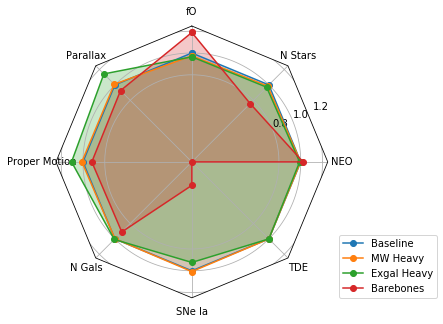

In [30]:
fig, axes = plt.subplots(figsize=(5, 5), subplot_kw=dict(projection='radar'))
axes.set_rgrids([0.8, 1.0, 1.2, 1.5])

data = subDF.loc[baseline, :]
axes.plot(theta, data, 'o-', label='Baseline')
axes.fill(theta, data, alpha=0.25, label='')


data = subDF.loc['mw_heavy', :]
axes.plot(theta, data, 'o-', label='MW Heavy')
axes.fill(theta, data, alpha=0.25, label='')

data = subDF.loc['rolling_exgal_mod2_dust_sdf_0.20', :]
axes.plot(theta, data, 'o-', label='Exgal Heavy')
axes.fill(theta, data, alpha=0.25, label='')

data = subDF.loc['barebones', :]
axes.plot(theta, data, 'o-', label='Barebones')
axes.fill(theta, data, alpha=0.25, label='')


axes.set_varlabels(metric_names)
axes.legend(loc=(1.04,0))

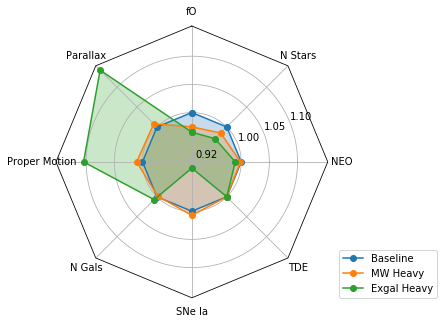

In [29]:
fig, axes = plt.subplots(figsize=(5, 5), subplot_kw=dict(projection='radar'))
axes.set_rgrids([0.92, 1.0, 1.05, 1.1])

data = subDF.loc[baseline, :]
axes.plot(theta, data, 'o-', label='Baseline')
axes.fill(theta, data, alpha=0.25, label='')

#data = subDF.loc['barebones', :]
#axes.plot(theta, data, 'o-', label='Barebones')
#axes.fill(theta, data, alpha=0.25, label='')

data = subDF.loc['mw_heavy', :]
axes.plot(theta, data, 'o-', label='MW Heavy')
axes.fill(theta, data, alpha=0.25, label='')

data = subDF.loc['rolling_exgal_mod2_dust_sdf_0.20', :]
axes.plot(theta, data, 'o-', label='Exgal Heavy')
axes.fill(theta, data, alpha=0.25, label='')


axes.set_varlabels(metric_names)
axes.legend(loc=(1.04,0))